# Поиск изображения по текстовому описанию

## Постановка задачи

Необходимо разработать демонстрационную версию поиска изображений по текстовому запросу.<br>
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. 

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. 

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно несколько описаний.

В папке `test_images` содержатся изображения для тестирования модели.

In [ ]:
!pip install -q transformers catboost optuna keras-tuner

## Импорт библиотек, настройки

<div class="alert alert-info"> <b>🔵 Комментарий</b>

Код из следующей ячейки нужен, чтоб активировать GPU для LGBM в Colab.
</div>

In [ ]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM
!mkdir build
!cmake -DUSE_GPU=1
!make -j$(nproc)
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile
%cd /content

fatal: destination path 'LightGBM' already exists and is not an empty directory.
/content/LightGBM
mkdir: cannot create directory ‘build’: File exists
CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.


-- OpenCL include directory: /usr/include
-- Using _mm_prefetch
-- Using _mm_malloc
-- Configuring done
-- Generating done
-- Build files have been written to: /content/LightGBM
[  1%] Building CXX object CMakeFiles/lightgbm_capi_objs.dir/src/c_api.cpp.o
[  3%] Building CXX object CMakeFiles/lightgbm_objs.dir/src/boosting/boosting.cpp.o
In file included from /content/LightGBM/include/LightGBM/config.h:16,
                 from /content/LightGBM/include/LightGBM/boosting.h:8,
                 from /content/LightGBM/src/c_api.cpp:7:
/content/LightGBM/include/LightGBM/utils/common.h:33:10: fatal error: ../../../external_libs/fast_d

In [ ]:
import os

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import notebook

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk import word_tokenize, pos_tag

from transformers import BertTokenizer, TFBertModel

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
from lightgbm import LGBMRegressor

from catboost import CatBoostRegressor

import optuna

import warnings
warnings.filterwarnings('ignore')

Установка констант

In [ ]:
RND_ST=42
IMG_SHAPE=(224, 224, 3)
N_FOLDS=3

Устанавливаем параметры для воспроизводимости результатов [ссылка](https://stackoverflow.com/questions/50659482/why-cant-i-get-reproducible-results-in-keras-even-though-i-set-the-random-seeds)

In [ ]:
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(RND_ST)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(RND_ST)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(RND_ST)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(RND_ST)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Проверяем активность **GPU**

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Num GPUs Available:  1
Found GPU at: /device:GPU:0


## Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение - текст имеются оценки от трёх специалистов. Для аггрегации оценок экспертов удобно превратить эти три оценки в одну.

### Загрузка данных

In [ ]:
if os.path.exists('/content/prjct.zip') == False:
    print('Загрузка данных...')
    !wget -q https://~~
    !unzip -q ~~
else:
    print('Данные уже загружены')
    
DATA_PATH = '/content/to_upload'

Загрузка данных...


### 1.2 Чтение данных

In [ ]:
train_df = pd.read_csv(DATA_PATH + '/train_dataset.csv')
train_df.sample(5, random_state=RND_ST)

image                     query_id  \
544    542317719_ed4dd95dc2.jpg  3591458156_f1a9a33918.jpg#2   
1894  3301811927_a2797339e5.jpg  3301811927_a2797339e5.jpg#2   
5546  3516825206_5750824874.jpg  2944362789_aebbc22db4.jpg#2   
4923  2498897831_0bbb5d5b51.jpg  3677318686_b018862bb7.jpg#2   
3624  2358561039_e215a8d6cd.jpg  1287073593_f3d2a62455.jpg#2   

                                             query_text  
544            A man at a rodeo is thrown off a horse .  
1894            Hockey players with one taking a shot .  
5546  A skateboarder is skating down a very steep ra...  
4923  A little boy in a purple shirt and blue shorts...  
3624               Dogs pulling a sled in a sled race .

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [ ]:
test_df = pd.read_csv(DATA_PATH + '/test_queries.csv', sep='|', index_col=[0])
test_df.sample(5, random_state=RND_ST)

query_id  \
361  3482859574_3908de3427.jpg#1   
73   2141713971_e25eb12712.jpg#3   
374  3488087117_2719647989.jpg#4   
155   269650644_059a84ece5.jpg#0   
104  2428094795_d3a8f46046.jpg#4   

                                            query_text  \
361  A group of girls who are gothically dressed st...   
73   A woman and girl riding downhill on a sled wit...   
374                               The dog is running .   
155  A group of people are ice skating in a big city .   
104  Little kid in blue coat and hat riding a tricy...   

                         image  
361  3482859574_3908de3427.jpg  
73   2141713971_e25eb12712.jpg  
374  3488087117_2719647989.jpg  
155   269650644_059a84ece5.jpg  
104  2428094795_d3a8f46046.jpg

In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


In [ ]:
test_img = pd.read_csv(DATA_PATH + '/test_images.csv')
test_img.sample(5, random_state=RND_ST)

image
83  2505056124_1276e8dbcb.jpg
53  3553476195_fb3747d7c1.jpg
70  1580671272_3e99d94305.jpg
45  2517284816_9b8fd3c6b6.jpg
44  3184031654_34b5c4ffe1.jpg

In [ ]:
test_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 928.0+ bytes


In [ ]:
len(set(test_img['image']).symmetric_difference(set(test_df['image'])))

0

Данные, содержащиеся в `test_img`, полностью присутствуют в `test_df`, так что достаточно только данных из `test_df`

In [ ]:
del test_img

In [ ]:
crowd_annot = pd.read_csv(DATA_PATH + '/CrowdAnnotations.tsv', sep='\t', header=None)
crowd_annot.sample(5, random_state=RND_ST +15)

0                            1         2  3  4
41707   375392855_54d46ed5c8.jpg   401079494_562454c4d6.jpg#2  0.000000  0  3
32307  3384314832_dffc944152.jpg  3474406285_01f3d24b71.jpg#2  1.000000  3  0
31352  3350786891_6d39b234e9.jpg  3350786891_6d39b234e9.jpg#2  0.333333  1  2
46730   751737218_b89839a311.jpg  2731171552_4a808c7d5a.jpg#2  0.000000  0  3
39755  3639967449_137f48b43d.jpg  3053743109_a2d780c0d2.jpg#2  0.000000  0  3

In [ ]:
crowd_annot.columns=['image', 
                     'query_id', 
                     'crowd_rate', 
                     'num_positive', 
                     'num_negative']
crowd_annot.sample(5, random_state=RND_ST +15)

image                     query_id  crowd_rate  \
41707   375392855_54d46ed5c8.jpg   401079494_562454c4d6.jpg#2    0.000000   
32307  3384314832_dffc944152.jpg  3474406285_01f3d24b71.jpg#2    1.000000   
31352  3350786891_6d39b234e9.jpg  3350786891_6d39b234e9.jpg#2    0.333333   
46730   751737218_b89839a311.jpg  2731171552_4a808c7d5a.jpg#2    0.000000   
39755  3639967449_137f48b43d.jpg  3053743109_a2d780c0d2.jpg#2    0.000000   

       num_positive  num_negative  
41707             0             3  
32307             3             0  
31352             1             2  
46730             0             3  
39755             0             3

In [ ]:
crowd_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   crowd_rate    47830 non-null  float64
 3   num_positive  47830 non-null  int64  
 4   num_negative  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [ ]:
exp_annot = pd.read_csv(DATA_PATH + '/ExpertAnnotations.tsv', sep='\t', header=None)
exp_annot.sample(5, random_state=RND_ST)

0                            1  2  3  4
544    172097782_f0844ec317.jpg  3641022607_e7a5455d6c.jpg#2  3  4  4
1894  2621415349_ef1a7e73be.jpg  2675685200_0913d84d9b.jpg#2  1  1  2
5546   539751252_2bd88c456b.jpg  3564543247_05cdbc31cf.jpg#2  2  3  3
4923  3694093650_547259731e.jpg  2204550058_2707d92338.jpg#2  1  1  1
3624  3263395801_5e4cee2b9e.jpg  1554713437_61b64527dd.jpg#2  1  2  2

In [ ]:
exp_annot.columns=['image', 
                   'query_id', 
                   'exp_1', 
                   'exp_2', 
                   'exp_3']
exp_annot.sample(5, random_state=RND_ST)

image                     query_id  exp_1  exp_2  \
544    172097782_f0844ec317.jpg  3641022607_e7a5455d6c.jpg#2      3      4   
1894  2621415349_ef1a7e73be.jpg  2675685200_0913d84d9b.jpg#2      1      1   
5546   539751252_2bd88c456b.jpg  3564543247_05cdbc31cf.jpg#2      2      3   
4923  3694093650_547259731e.jpg  2204550058_2707d92338.jpg#2      1      1   
3624  3263395801_5e4cee2b9e.jpg  1554713437_61b64527dd.jpg#2      1      2   

      exp_3  
544       4  
1894      2  
5546      3  
4923      1  
3624      2

In [ ]:
exp_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp_1     5822 non-null   int64 
 3   exp_2     5822 non-null   int64 
 4   exp_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [ ]:
for folder_name in ('train_images', 'test_images'):
    num_skipped = 0
    folder_path = os.path.join(DATA_PATH +'/', folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, 'rb')
            is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(20)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1

    print("В папке < %s > найдено %d поврежденных файлов" % (folder_name, num_skipped))

В папке < train_images > найдено 0 поврежденных файлов
В папке < test_images > найдено 1 поврежденных файлов


<div class="alert alert-info"> <b>🔵 Комментарий</b>

1 файл в тестовых данных опознан как поврежденный. Ниже будет понятно, что это файл `.DS_Store`.
</div>

Выведем примеры изображений из тренировочной и тестовой выборки и описаний к ним. Случайно выберем 10 пар "изображение - описание": загружаем случайный батч из 10 пар "изображение - описание", затем случайно выбираем из батча пару "изображение - описание".

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

sample_train_flow = datagen.flow_from_dataframe(
        dataframe=train_df[['image','query_text']].sample(100, random_state=RND_ST),
        directory=DATA_PATH + '/train_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=RND_ST)

sample_test_flow = datagen.flow_from_dataframe(
        dataframe=test_df[['image','query_text']].sample(100, random_state=RND_ST),
        directory=DATA_PATH + '/test_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=RND_ST)

Found 100 validated image filenames.
Found 100 validated image filenames.


In [ ]:
def img_randprint(generator, img_rows, img_columns, fig_title, btch_space=1, btch_size=1): 
    
    '''btch_space может быть (generator.samples//btch_size +1)'''
    
    fig, ax = plt.subplots(img_rows, img_columns, figsize=(img_columns*8, img_rows*3))
    for i in range(img_rows*img_columns):
        batch_num = np.random.randint(btch_space)    
        img_num = np.random.randint(btch_size)
        generator.reset()
        for _ in range(batch_num):
            fch, target = next(generator)
        ax[i//img_columns][i%img_columns].imshow(fch[img_num])
        ax[i//img_columns][i%img_columns].set_title(str(target[img_num]), fontsize=12)
        ax[i//img_columns][i%img_columns].axis ('off')
    fig.suptitle(fig_title, y=0.95, fontsize=18)
    plt.show()

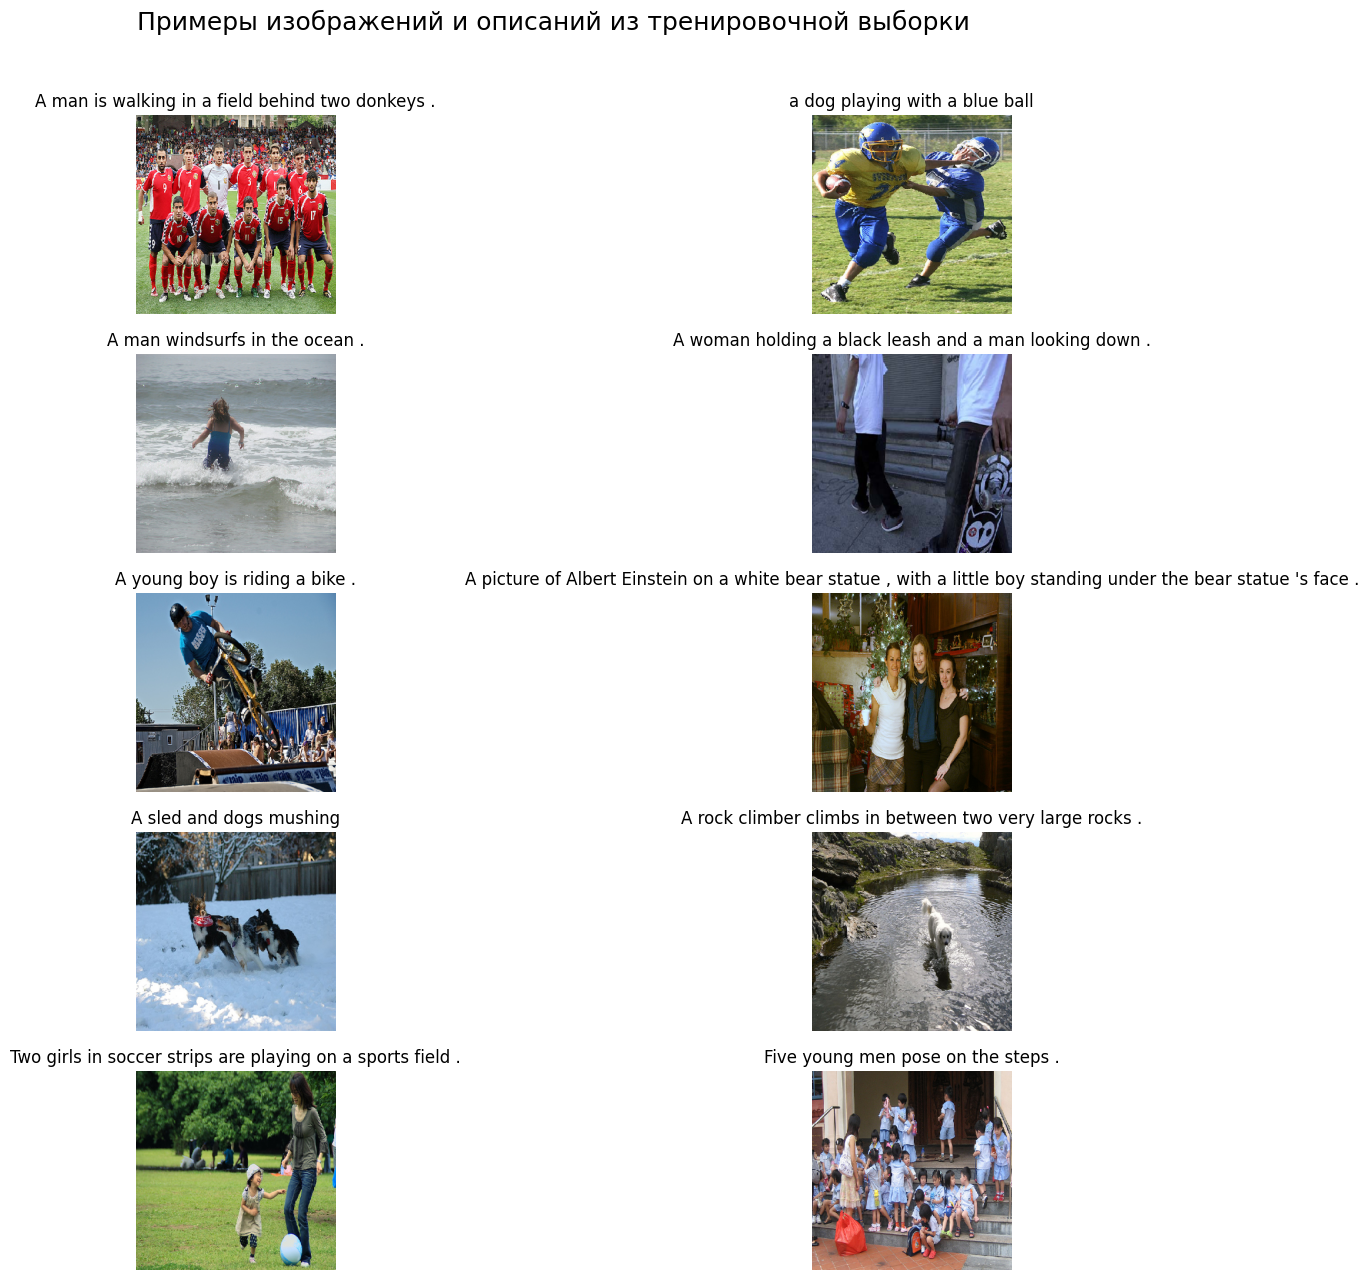

In [ ]:
img_randprint(sample_train_flow,
              5, 2,
              'Примеры изображений и описаний из тренировочной выборки',
              sample_train_flow.samples//10,
              10)

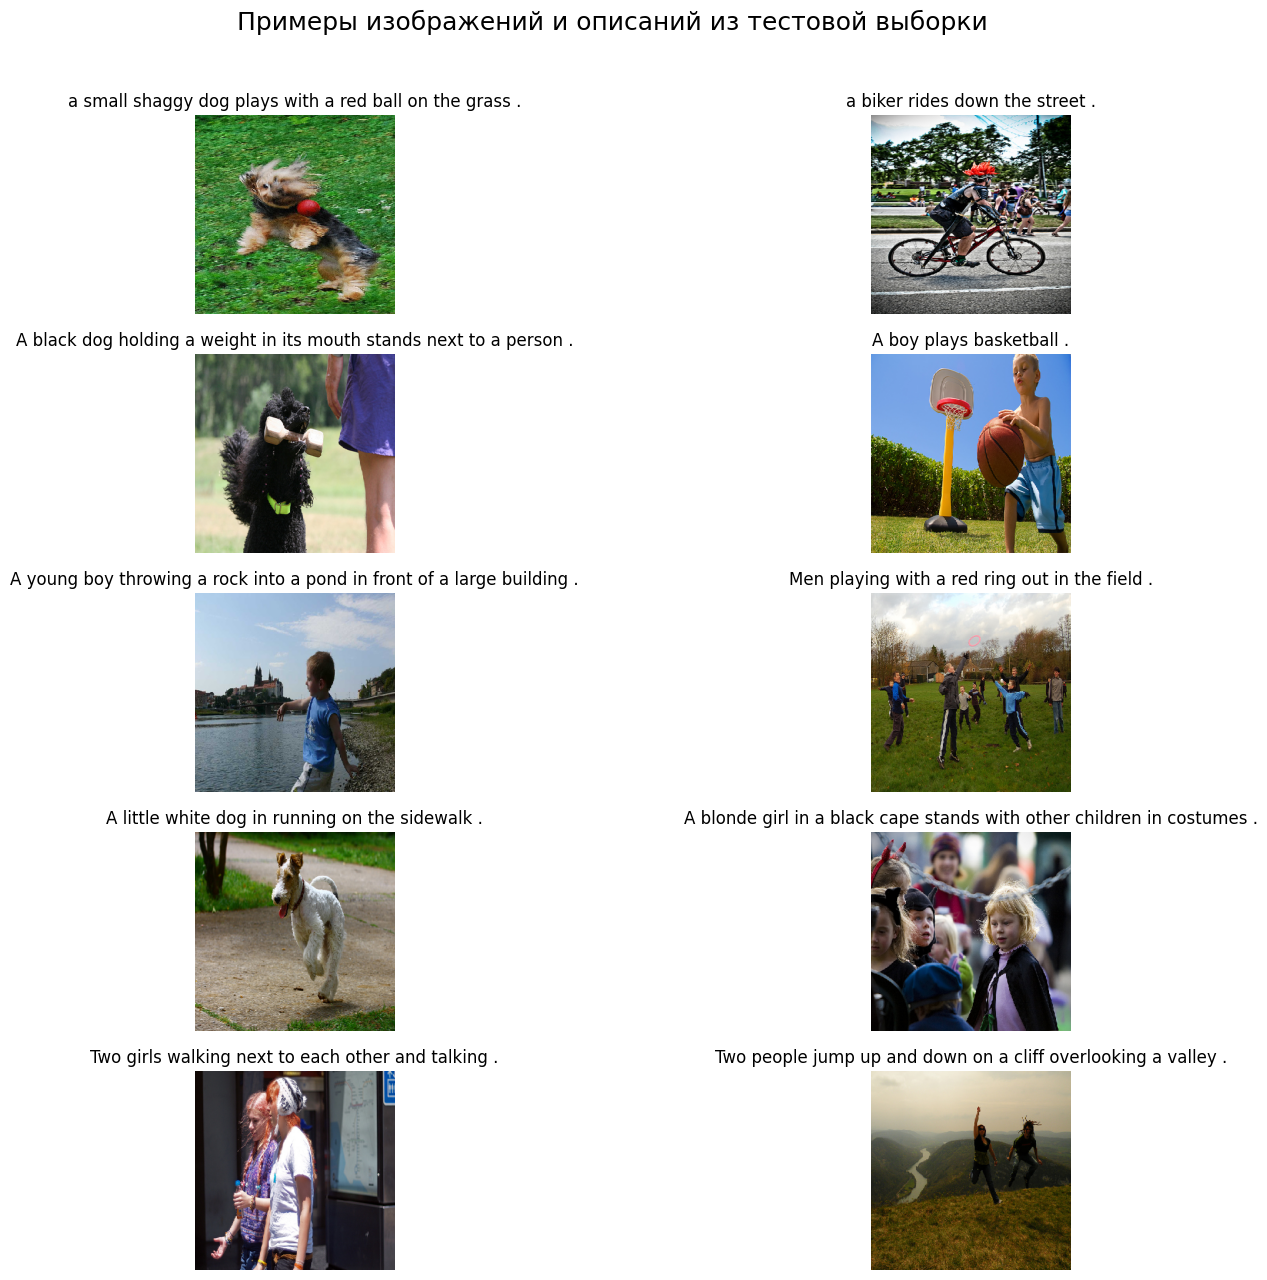

In [ ]:
img_randprint(sample_test_flow,
              5, 2,
              'Примеры изображений и описаний из тестовой выборки',
              sample_test_flow.samples//10, 10)

В тренировочных данных очень немногие описания действительно соответствуют тому, что изображено на картинке. В тестовых данных соответствие описания картинке - намного лучше.

In [ ]:
del sample_train_flow, sample_test_flow

### 1.3 Анализ данных

Проверка полноты данных. Проверяем что список имен изображений в файлах соответствует именам файлов изображений в соответствующих папках. Также проверяем сответствие в файлах для идентификаторов аннотаций.

In [ ]:
'''список файлов из тренировочных данных'''

train_img_list = []
for (dirpath, dirnames, filenames) in os.walk(DATA_PATH + '/train_images'):
    train_img_list.extend(filenames)
    break

del dirpath, dirnames, filenames

In [ ]:
print( len(set(train_df['image']).symmetric_difference(set(train_img_list))) )
print( len(set(train_df['image']).symmetric_difference(set(crowd_annot['image']))) )
print( len(set(crowd_annot['image']).symmetric_difference(set(exp_annot['image']))) )

del train_img_list

0
0
0


Все изображения присутствуют в данных аннотаций `crowd_annot` и `exp_annot` и данных с описаниями `train_df`

In [ ]:
'''список файлов из тестовых данных'''

test_img_list = []
for (dirpath, dirnames, filenames) in os.walk(DATA_PATH + '/test_images'):
    test_img_list.extend(filenames)
    break

del dirpath, dirnames, filenames

In [ ]:
print( set(test_df['image']).symmetric_difference(set(test_img_list)) )

del test_img_list

{'.DS_Store'}


Все изображения присутствуют в данных с описаниями `test_df`

In [ ]:
print( len(set(crowd_annot['query_id']).symmetric_difference(set(exp_annot['query_id']))) )
print( len(set(crowd_annot['query_id']).symmetric_difference(set(train_df['query_id']))) )
print( len(set(exp_annot['query_id']).symmetric_difference(set(train_df['query_id']))) )


23
23
0


В данных с аннотацией пользователей `crowd_annot` присутствуют 23 идентификатора аннотации, которых нет в `exp_annot` и `train_df`. Идентификаторам из таблицы ниже не найдется текстовое соответствие в данных `train_df`.

In [ ]:
lost_query_id = (
    crowd_annot[
        crowd_annot["query_id"].isin(
            set(crowd_annot["query_id"]).symmetric_difference(
                set(exp_annot["query_id"])
            )
        )
    ]
    .groupby(by="query_id", as_index=False)
    .agg({"image": "count"})
    .sort_values("image", ascending=False)
    .reset_index(drop=True)
    .rename(columns={"image": "image_link_qty"})
)
display(
    lost_query_id.append(
        {"query_id": "ВСЕГО", 
         "image_link_qty": lost_query_id["image_link_qty"].sum()},
        ignore_index=True,
    )
)

query_id  image_link_qty
0   2431832075_00aa1a4457.jpg#2             113
1    223299142_521aedf9e7.jpg#2              79
2   3375549004_beee810e60.jpg#2              72
3   2054869561_ff723e9eab.jpg#2              70
4   3116769029_f5a76f04ba.jpg#2              58
5   1343426964_cde3fb54e8.jpg#2              56
6   2479162876_a5ce3306af.jpg#2              55
7   3019842612_8501c1791e.jpg#2              52
8   3015863181_92ff43f4d8.jpg#2              49
9   3427118504_93126c83e0.jpg#2              44
10  2194494220_bb2178832c.jpg#2              42
11  3523559027_a65619a34b.jpg#2              42
12  3387542157_81bfd00072.jpg#2              42
13  3185371756_ff4e9fa8a6.jpg#2              40
14  2482629385_f370b290d1.jpg#2              36
15  3499720588_c32590108e.jpg#2              35
16  3203453897_6317aac6ff.jpg#2              35
17  2806710650_e201acd913.jpg#2              35
18  3349451628_4249a21c8f.jpg#2              34
19  3521374954_37371b49a4.jpg#2              31
20  3149919755_f9272b10b3.jpg#2              30
21  2913965136_2d00136697.jpg#2              30
22    86412576_c53392ef80.jpg#2              29
23                        ВСЕГО            1109

Проверяем соответствие идентификаторов описаний в терниеровочных и тестовых данных

In [ ]:
print('Уникальных описаний в тренировочных данных:', train_df['query_id'].nunique())
print('Уникальных описаний в тестовых данных:', test_df['query_id'].nunique())
print('Кол-во пересечений:', len(set(test_df['query_id']) & set(train_df['query_id'])) )

Уникальных описаний в тренировочных данных: 977
Уникальных описаний в тестовых данных: 500
Кол-во пересечений: 0


Описания в тренировочных и тестовых данных полностью **НЕ** совпадают

Проверим, есть ли комбинации оценок экспертов, где разница между мин. и макс. оценками более 2

In [ ]:
exp_scores = list(zip(exp_annot['exp_1'], exp_annot['exp_2'], exp_annot['exp_3']))
toxic_scores = [ item for item in exp_scores if (np.max(item) - np.min(item))>2 ]
toxic_index = [i for i, x in enumerate(exp_scores) if x == toxic_scores[0]]
print(toxic_scores)
print(toxic_index)
exp_annot.loc[toxic_index]

[(1, 2, 4), (1, 2, 4), (1, 4, 4)]
[3956, 5561]


image                     query_id  exp_1  exp_2  \
3956  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2      1      2   
5561   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2      1      2   

      exp_3  
3956      4  
5561      4

Среди комбинаций оценок экспертов нашлись 3 записи, где разница между макс. и мин. оценками более 2. Варианты с комбинацией (1, 2, 4) лучше удалить из `exp_annot`

In [ ]:
exp_annot = exp_annot.drop(toxic_index)
del toxic_index

Посмотрим на распределение оценок экспертов. По аналогии с пользователяеми введем нормализованный "индекс соответствия" для экспертов, который будем вычислять как: $$\frac{(exp_1 + exp_2 + exp_3) -3}{9}$$

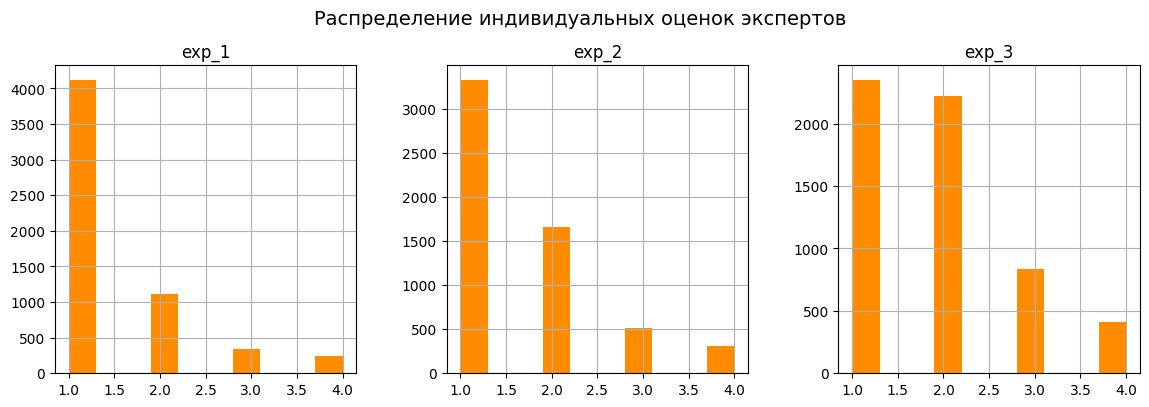

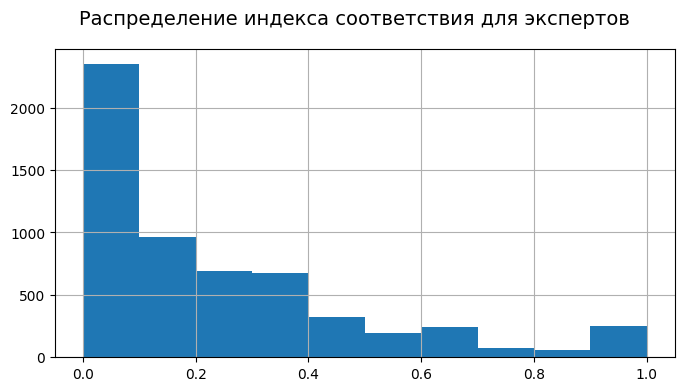

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))
exp_annot[['exp_1', 'exp_2', 'exp_3']].hist(ax=ax, color='darkorange')
fig.suptitle('Распределение индивидуальных оценок экспертов', y=1.02, fontsize=14)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
exp_annot.assign( exp_rate = lambda x: ((x.exp_1 + x.exp_2 + x.exp_3) -3) /9 )['exp_rate'].hist(ax=ax, bins=10)
fig.suptitle('Распределение индекса соответствия для экспертов', fontsize=14)
plt.show()

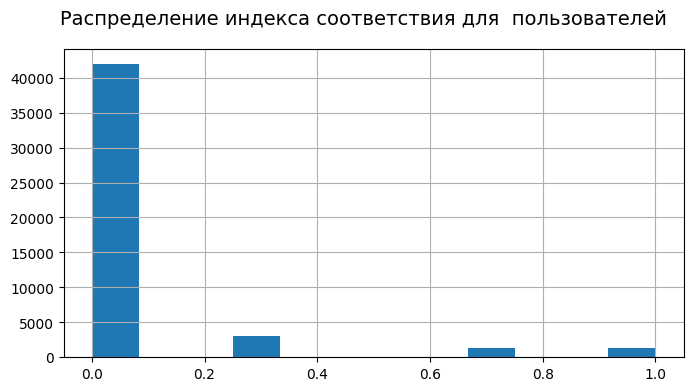

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
crowd_annot['crowd_rate'].hist(bins=len(crowd_annot['crowd_rate'].value_counts()), ax=ax)
fig.suptitle('Распределение индекса соответствия для  пользователей', fontsize=14)
plt.show()

Будем принимать во внимание как оценки экспертов, так и оценки пользователей. Для этого нам потребуется:

1. объединить два датафрейма `train_df` и `exp_annot` (со столбцом `exp_rate`) по ключам `['image', 'query_id']` методом `outer`;


2. к получившемуся файлу добавить `crowd_annot` по ключам `['image', 'query_id']` методом `outer`;


3. поля `['exp_1', 'exp_2', 'exp_3']` и `['num_positive', 'num_negaive']` удалим;


4. образовавшиеся пропуски в поле `query_text` заполнить, опираясь на значение `query_id`;


5. в `query_text` останутся только пропуски в тех местах, где идентификатор `query_id`, связанный с соответствующим `image` пришел из `crowd_annot` так как мы объединяли `outer`. Как мы видели выше, таких комбинаций `query_id` с полем `image` должно быть 1109. Эти строки удалим;


6. образуются пропуски в полях `exp_rate` и `crowd_rate` так как комбинации в полях `image` и `query_id` в файлах `train_df` и `crowd_annot` не одинаковые. На основании оценок в полях `crowd_rate` и `exp_rate` рассчитаем сводный индекс `sum_rate` по такому правилу:
  - если есть обе оценки, то складываем с весами `0.6` и `0.4` для экспертов и пользователей соотв.;
  - если есть только одна из оценок, то сводный индекс `sum_rate` принимаем равным этой оценке
</div>

In [ ]:
# шаги 1, 2 и 3

train_merge = (
    train_df.merge(exp_annot, "outer", ["image", "query_id"])
    .assign(exp_rate=lambda x: ((x.exp_1 + x.exp_2 + x.exp_3) - 3) / 9)
    .merge(crowd_annot, "outer", ["image", "query_id"])
    .drop(["exp_1", "exp_2", "exp_3", "num_positive", "num_negative"], axis=1)
)

In [ ]:
# шаг 4, создание словаря

query_id_query_text_dict = pd.Series(
    data=train_merge[["query_id", "query_text"]]
    .dropna()
    .drop_duplicates()
    .sort_values("query_id")["query_text"]
    .values,
    index=train_merge[["query_id", "query_text"]]
    .dropna()
    .drop_duplicates()
    .sort_values("query_id")["query_id"]
    .values,
).to_dict()
print(
    "В словаре %g элементов вида: " % len(query_id_query_text_dict),
    list(query_id_query_text_dict.items())[:1],
)

В словаре 977 элементов вида:  [('1056338697_4f7d7ce270.jpg#2', 'A woman is signaling is to traffic , as seen from behind .')]


In [ ]:
# шаг 4, заполнение пропусков на базе словаря

train_merge['query_text'] = train_merge['query_id'].map(query_id_query_text_dict)
train_merge.isna().sum()

image             0
query_id          0
query_text     1109
exp_rate      45503
crowd_rate     3493
dtype: int64

In [ ]:
# шаг 5

train_merge = train_merge.dropna(subset=['query_text'], axis=0)
train_merge.isna().sum()

image             0
query_id          0
query_text        0
exp_rate      44394
crowd_rate     3493
dtype: int64

Как видим, при удалении пропусков в `query_text` значение пропусков в `exp_rate` уменьшилось ровно на 1109, как и было подсчитано выше для идентификаторов, которые присутствуют в `crowd_annot`, но отсутствуют в `train_df` и `exp_annot`. В столбце `crowd_rate` значение пропусков не поменялось т.к. в удаленных строках отсутствовали менно оценки экспертов `exp_rate` поскольку удаленные строки пришли из датафрейма `crowd_annot`

In [ ]:
# шаг 6, создание масок
# проверка правильности создания путем сравнения с числом пропусков в столбцах
# проверка полноты по совокупности условий и длине файла

exp_mask = ~np.isnan(train_merge["exp_rate"])
crowd_mask = ~np.isnan(train_merge["crowd_rate"])
both_mask = exp_mask & crowd_mask

print("\nПроверка по числу пропусков")
print(len(train_merge) - exp_mask.sum())
print(len(train_merge) - crowd_mask.sum())

print("\nПроверка полноты по совокупности условий и длине файла")
print(
    sum(exp_mask & ~crowd_mask)
    + sum(~exp_mask & crowd_mask)
    + sum(both_mask)
    + sum(~exp_mask & ~crowd_mask & ~both_mask)
)

print(len(train_merge))


Проверка по числу пропусков
44394
3493

Проверка полноты по совокупности условий и длине файла
50214
50214


Для комбинаций ниже не нашлось вообще никаких оценок.
Эти комбинации присутствовали в `train_df`, но не входили ни в `exp_annot` ни в `crowd_annot`

In [ ]:
train_merge.loc[
    (~both_mask & ~exp_mask & ~crowd_mask)[
        (~both_mask & ~exp_mask & ~crowd_mask)
    ].index,
    :,
]

image                     query_id  \
1387   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2   
5171  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2   

                                             query_text  exp_rate  crowd_rate  
1387  An officer stands next to a car on a city stre...       NaN         NaN  
5171  The room full of youths reacts emotionally as ...       NaN         NaN

In [ ]:
# шаг 6, расчет сводного индекса

experts_rate_only_indx = (exp_mask & ~crowd_mask)[exp_mask & ~crowd_mask].index
train_merge.loc[experts_rate_only_indx, "sum_rate"] = train_merge.loc[
    experts_rate_only_indx, "exp_rate"
]

crowd_rate_only_indx = (~exp_mask & crowd_mask)[~exp_mask & crowd_mask].index
train_merge.loc[crowd_rate_only_indx, "sum_rate"] = train_merge.loc[
    crowd_rate_only_indx, "crowd_rate"
]

both_indx = (both_mask)[both_mask].index
train_merge.loc[both_indx, "sum_rate"] = (
    train_merge.loc[both_indx, "exp_rate"] * 0.6
    + train_merge.loc[both_indx, "crowd_rate"] * 0.4
)

train_merge = train_merge.drop(columns=["exp_rate", "crowd_rate"])

In [ ]:
train_merge.isna().sum()

image         0
query_id      0
query_text    0
sum_rate      2
dtype: int64

In [ ]:
train_merge[train_merge['sum_rate'].isna()]

image                     query_id  \
1387   542179694_e170e9e465.jpg   300577375_26cc2773a1.jpg#2   
5171  3388330419_85d72f7cda.jpg  3358558292_6ab14193ed.jpg#2   

                                             query_text  sum_rate  
1387  An officer stands next to a car on a city stre...       NaN  
5171  The room full of youths reacts emotionally as ...       NaN

Остались только две комбинации, которые мы вычислили ранее. Удалим эти строки.

In [ ]:
train_merge = train_merge.dropna(subset=['sum_rate'], axis=0)
train_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50212 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50212 non-null  object 
 1   query_id    50212 non-null  object 
 2   query_text  50212 non-null  object 
 3   sum_rate    50212 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
del crowd_annot, exp_annot, train_df

### Лемматизация и фильтрация текстовых описаний

Для леммантизации выделим уникальные описания

In [ ]:
id_text_df = train_merge[['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
def text_prep(text):
    """
    функция очистки от пунктуации, токенизации с удалением stop-слов
    """
    # оставляем только буквы
    text_prep = re.sub(r"[^a-zA-Z]", " ", text)  
    lemm_lst = []
    # разбиваем на токены и получаем отметки о части речи
    for token, tag in pos_tag(word_tokenize(text_prep.lower())):
        pos = tag[0].lower()
        if pos not in ["a", "r", "n", "v"]:
            pos = "n"
        # лемматизируем
        lemm_lst.append(wnl.lemmatize(token, pos)) 
    # убираем stopwords
    filtered_lst = [
        word for word in lemm_lst if word not in nltk_stopwords.words("english")
        ]  
    return " ".join(filtered_lst)

In [ ]:
text_lemm = []
batch_size = 100
for i in notebook.tqdm( range(id_text_df.shape[0]//batch_size +1) ):
    batch = id_text_df['query_text'][batch_size*i : batch_size*(i+1)]
    batch_lemm = batch.apply(text_prep)
    text_lemm = text_lemm + batch_lemm.to_list()

id_text_df['query_text_lemm_fltr'] = pd.Series(text_lemm, index=id_text_df.index)

  0%|          | 0/10 [00:00<?, ?it/s]

Выведем результат для просмотра. Теперь в столбце `query_text_lemm_fltr` содержится очищенный от пунктуации и от стоп-слов лемматизированный текст.

In [ ]:
id_text_df

query_id  \
0    2549968784_39bfbe44f9.jpg#2   
1    2718495608_d8533e3ac5.jpg#2   
2    3181701312_70a379ab6e.jpg#2   
3    3207358897_bfa61fa3c6.jpg#2   
4    3286822339_5535af6b93.jpg#2   
..                           ...   
972  2061144717_5b3a1864f0.jpg#2   
973  2196107384_361d73a170.jpg#2   
974  2112921744_92bf706805.jpg#2   
975  3651971126_309e6a5e22.jpg#2   
976  2292406847_f366350600.jpg#2   

                                            query_text  \
0    A young child is wearing blue goggles and sitt...   
1    A girl wearing a yellow shirt and sunglasses s...   
2      A man sleeps under a blanket on a city street .   
3    A woman plays with long red ribbons in an empt...   
4           Chinese market street in the winter time .   
..                                                 ...   
972         A man in an ampitheater talking to a boy .   
973          a old man walks down the uncrowded road .   
974       A dog stands on the side of a grassy cliff .   
975                       A blurry photo of two dogs .   
976                        A man rows his boat below .   

                             query_text_lemm_fltr  
0    young child wear blue goggles sit float pool  
1           girl wear yellow shirt sunglass smile  
2                   man sleep blanket city street  
3         woman play long red ribbon empty square  
4               chinese market street winter time  
..                                            ...  
972                      man ampitheater talk boy  
973                   old man walk uncrowded road  
974                   dog stand side grassy cliff  
975                          blurry photo two dog  
976                                  man row boat  

[977 rows x 3 columns]

Преобразуем в словарь, где ключами будут `query_id`, а значениями - `query_text_lemm_fltr`

In [ ]:
id_text_dict = pd.Series(
    id_text_df.query_text_lemm_fltr.values, index=id_text_df.query_id
).to_dict()
print(
    "В словаре %g элементов вида: " % len(id_text_dict), list(id_text_dict.items())[:1]
)

В словаре 977 элементов вида:  [('2549968784_39bfbe44f9.jpg#2', 'young child wear blue goggles sit float pool')]


### Компоновка итогового датафрейма для тренировочных данных

Создадим новый столбец `query_text_lemm_fltr` из лемматизированных и отфильтрованных описаний

In [ ]:
train_merge['query_text_lemm_fltr'] = train_merge['query_id'].map(lambda x: id_text_dict.get(x))
train_merge.sample(7, random_state=RND_ST)

image                     query_id  \
22385  2729655904_1dd01922fb.jpg  3048597471_5697538daf.jpg#2   
12547  2189995738_352607a63b.jpg  2878272032_fda05ffac7.jpg#2   
16963  2458269558_277012780d.jpg  1561658940_a947f2446a.jpg#2   
29174  3107513635_fe8a21f148.jpg  3115174046_9e96b9ce47.jpg#2   
45827   401079494_562454c4d6.jpg  3009644534_992e9ea2a7.jpg#2   
32182  3217910740_d1d61c08ab.jpg  2577972703_a22c5f2a87.jpg#2   
50395   757046028_ff5999f91b.jpg   488356951_b3b77ad832.jpg#2   

                                              query_text  sum_rate  \
22385  A dog wading in the water with a ball in his m...  0.000000   
12547                           dogs playing in a stream  0.000000   
16963        A little girl sits in a plastic swing set .  0.666667   
29174                 a skateboarder jumps a staircase .  0.000000   
45827                  A dog fetches a ball in a field .  0.000000   
32182         A little girl with mud on her face cries .  0.000000   
50395  Talk between man in Hawaiian shirt , older man...  0.000000   

                                    query_text_lemm_fltr  
22385                        dog wading water ball mouth  
12547                                    dog play stream  
16963                 little girl sits plastic swing set  
29174                        skateboarder jump staircase  
45827                               dog fetch ball field  
32182                           little girl mud face cry  
50395  talk man hawaiian shirt older man gray man see...

In [ ]:
train_merge[
    ['image', 'query_id', 'query_text_lemm_fltr', 'sum_rate']
].isna().sum()

image                   0
query_id                0
query_text_lemm_fltr    0
sum_rate                0
dtype: int64

Создадим датафрейм с предобработанными данными

In [ ]:
prep_train = train_merge[
    ['image', 'query_id', 'query_text', 'query_text_lemm_fltr', 'sum_rate']
].reset_index(drop=True)

In [ ]:
prep_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50212 entries, 0 to 50211
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 50212 non-null  object 
 1   query_id              50212 non-null  object 
 2   query_text            50212 non-null  object 
 3   query_text_lemm_fltr  50212 non-null  object 
 4   sum_rate              50212 non-null  float64
dtypes: float64(1), object(4)
memory usage: 1.9+ MB


## Проверка данных на `compliance`

Для изображений с описаниями, в которых есть **стоп**-слова, вместо картинок должен выводиться дисклеймер:

> This image is unavailable in your country in compliance with local laws

Все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [ ]:
compliance_words = ['child',
                    'girl',
                    'boy', 
                    'toddler', 
                    'kid', 
                    'baby', 
                    'teenager']

In [ ]:
prep_train['query_text_lemm_fltr'].str.contains('|'.join(compliance_words), regex=True).value_counts()

False    35820
True     14392
Name: query_text_lemm_fltr, dtype: int64

Есть записи, которые помогли бы понять модели, что картинка и описание не соответствуют. Если оценка ниже `threshold`, то это значит, что картинка НЕ соответствует "запрещенному описанию" и эту запись мы оставим. А вот если оценка выше `threshold`, то значит на картинке что-то запрещенное и тогда мы должны удалить такую запись.

У нас 55 вариантов оценок (см. ниже). Выберем `threshold = 0.6` с запасом.

In [ ]:
prep_train['sum_rate'].nunique()

55

In [ ]:
threshold = .6
compliance_indx = (
    prep_train[ (prep_train['query_text_lemm_fltr'].str.contains('|'.join(compliance_words), regex=True)) 
    & ( prep_train['sum_rate'] > threshold ) ].index
    )
print('Записей, удовлетворяющих условию:', len(compliance_indx))

Записей, удовлетворяющих условию: 494


In [ ]:
prep_train = prep_train.drop(compliance_indx)

In [ ]:
prep_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49718 entries, 0 to 50211
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 49718 non-null  object 
 1   query_id              49718 non-null  object 
 2   query_text            49718 non-null  object 
 3   query_text_lemm_fltr  49718 non-null  object 
 4   sum_rate              49718 non-null  float64
dtypes: float64(1), object(4)
memory usage: 2.3+ MB


Выведем небольшую статистику по датафрейму `prep_train` после проверки данных на compliance

In [ ]:
(
    pd.DataFrame(
        data={
            "Кол-во записей (строк)": prep_train.shape[0],
            "Кол-во уникальных изображений": prep_train["image"].nunique(),
            "Кол-во уникальных описаний": prep_train.nunique()[1],
            "Кол-во уникальных слов в описаниях": len(
                set(" ".join(prep_train["query_text_lemm_fltr"]).split())
            ),
            "Макс. кол-во слов в описании": prep_train["query_text_lemm_fltr"]
            .map(lambda s: len(s.split()))
            .max(),
            "Мин. кол-во слов в описании": prep_train["query_text_lemm_fltr"]
            .map(lambda s: len(s.split()))
            .min(),
            "Макс. число описаний для изображения": prep_train.groupby("image")
            .agg({"query_id": "count"})["query_id"]
            .max(),
            "Мин. число описаний для изображения": prep_train.groupby("image")
            .agg({"query_id": "count"})["query_id"]
            .min(),
            "Среднее число описаний для изображения": int(
                prep_train.groupby("image")
                .agg({"query_id": "count"})["query_id"]
                .mean()
            ),
            "Кол-во уникальных индексов соответствия": prep_train["sum_rate"].nunique(),
            "Средний индекс соответствия": prep_train["sum_rate"].mean(),
            "Доля индексов соответствия >= 0.5": prep_train[
                prep_train["sum_rate"] >= 0.5
            ]["sum_rate"].count()
            / prep_train.shape[0],
            "Доля индексов соответствия < 0.5": prep_train[
                prep_train["sum_rate"] < 0.5
            ]["sum_rate"].count()
            / prep_train.shape[0],
        },
        index=["Значение"],
    )
    .T.reset_index()
    .rename(columns={"index": "Параметр"})
    .style.format("{:.2f}", subset="Значение")
    .set_properties(**{"text-align": "right"})
)

В датафрейме `prep_train` собраны все необходимые данные для следующего шага.

## Векторизация изображений

Выбираем архитектуру ResNet50V2 из `keras.applications`. Исключим полносвязные слои, которые отвечают за конечное предсказание, оставляя слой GlobalAveragePooling2D. При этом загружаем модель данной архитектуры, предтренированную на датасете ImageNet.

In [ ]:
backbone = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling="avg",
)  # GlobalAveragePooling2D включен в модель
backbone.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
outputs = backbone(inputs)

fch_extraction = keras.Model(inputs, outputs, name='fch_extraction_model')

fch_extraction.summary()

94668760/94668760 [==============================] - 1s 0us/step
Model: "fch_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
# объект datagen включает масштабирование входных данных 1./255

train_img_flow = datagen.flow_from_dataframe(
    dataframe=prep_train[["image"]]
    .drop_duplicates()
    .sort_values("image")
    .reset_index(drop=True),
    directory=DATA_PATH + "/train_images",
    x_col="image",
    target_size=IMG_SHAPE[:2],
    batch_size=16,
    class_mode=None,
    subset=None,
    shuffle=False,
)

Found 1000 validated image filenames.


У нас `1000` уникальных изображений, соответственно нам нужно построить `1000` векторов.

In [ ]:
with tf.device('/device:GPU:0'):
    train_img_vectors = fch_extraction.predict(train_img_flow, verbose=1)

63/63 [==============================] - 14s 97ms/step


In [ ]:
train_img_vectors.shape, type(train_img_vectors)

((1000, 2048), numpy.ndarray)

Векторы изображений созданы: размерность совпадает: `1000` записей, `2048` - это размер выходного вектора предобученной модели.

## Векторизация текстов

Следующий этап — векторизация текстов. Выбираем  трансформер `Bert`.




In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
save_path = 'bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

('bert_base_uncased/tokenizer_config.json',
 'bert_base_uncased/special_tokens_map.json',
 'bert_base_uncased/vocab.txt',
 'bert_base_uncased/added_tokens.json')

In [ ]:
%%time
tokens_len = prep_train["query_text_lemm_fltr"].map(
    lambda s: len(
        tokenizer.encode(
            s, max_length=150, add_special_tokens=True, padding=False, truncation=True
        )
    )
)

CPU times: user 11.1 s, sys: 22.6 ms, total: 11.1 s
Wall time: 11.1 s


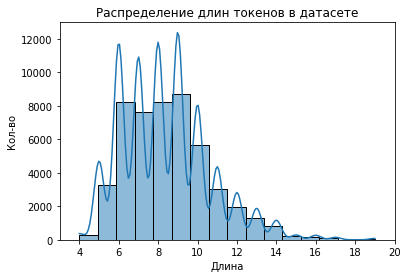

In [ ]:
sns.histplot(tokens_len, kde=True, bins=tokens_len.max()-tokens_len.min()+1)
plt.xlim([tokens_len.min()-1, tokens_len.max()+1])
plt.title('Распределение длин токенов в датасете')
plt.ylabel('Кол-во')
plt.xlabel('Длина');

Длины токенов в основоном в диапазоне `[5..12]`

Загружаем предобученную модель `TFBertModel`

In [ ]:
BERTencoder = TFBertModel.from_pretrained('bert-base-uncased')
BERTencoder.trainable = False

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Функция `text_embedding` для получения эмбеддингов для всех описаний из тренировочных данных

In [ ]:
def text_embedding(text, max_length=tokens_len.max()+1):
    
    # Преобразуем текст в токены:
    tokenized_series = text.apply(
        lambda x: tokenizer.encode(
            x, padding='max_length', max_length=max_length, return_tensors='np'
        )
    )
    tokenized = np.array([nest[0] for nest in tokenized_series])
   
   # Поясним модели, что нули не несут значимой информации и укажем нулевые и не нулевые значения:
    attention_mask = np.where(tokenized !=0, 1, 0)
    
    batch_size = 30
    embeddings = []

    for i in notebook.tqdm( range(tokenized.shape[0] // batch_size +1) ):
        # преобразуем данные
        batch = tf.constant( tokenized[batch_size*i : batch_size*(i+1)] )
        # преобразуем маску
        attention_mask_batch = tf.constant( attention_mask[batch_size*i : batch_size*(i+1)] )
        # получаем эмбеддинг для батча
        batch_embeddings = BERTencoder( batch, attention_mask = attention_mask_batch )
        # забираем нулевой элемент, а из него нулевой столбец
        embeddings.append( batch_embeddings[0][:, 0, :].numpy() )                               
    # собираем все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)                                                           

У нас `977` уникальных описания, соответственно нам нужно собрать `977` эмбеддингов.

In [ ]:
%%time
train_query_emb = text_embedding(
    prep_train['query_text_lemm_fltr']
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)

  0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 5.82 s, sys: 117 ms, total: 5.93 s
Wall time: 7.56 s


In [ ]:
train_query_emb.shape

(977, 768)

Ембеддинги созданы, размерность совпадает: `977` записи, `768` - это размер эмбеддинга предтренированной модели.

## Объединение векторов

Подготовим данные для обучения: объединим векторы изображений и векторы текстов с целевой переменной `sum_rate`.

Создаем справочный датфрейм для векторов изображений. Объединяем датафрейм векторов с упорядоченным датафреймов уникальных названий файлов изображений. Изначально мы передавали изображения в обработку именно в том порядке, в котором они содержались в упорядоченном датафрейме с названиями изображений, при этом параметр `shaffle` в загрузчике был установлен в `False`

In [ ]:
train_img_vectors_df = pd.DataFrame(train_img_vectors).join(
    prep_train[["image"]].drop_duplicates().sort_values("image").reset_index(drop=True)
)
train_img_vectors_df.columns = [
    "iv_" + str(colname) for colname in train_img_vectors_df.columns
]
train_img_vectors_df.rename(columns={"iv_image": "image"}, inplace=True)
display(train_img_vectors_df.head(3))
print(train_img_vectors_df.shape)

iv_0      iv_1      iv_2      iv_3      iv_4  iv_5      iv_6      iv_7  \
0  0.684464  0.019736  0.000000  0.268524  0.354971   0.0  1.240481  0.127548   
1  0.213394  0.030954  0.078492  0.000000  0.089402   0.0  0.100375  0.002159   
2  0.260063  0.473489  0.078431  0.507580  1.364986   0.0  0.728734  0.000000   

       iv_8      iv_9  ...   iv_2039   iv_2040   iv_2041   iv_2042   iv_2043  \
0  0.203643  0.000000  ...  0.035967  1.177608  0.002916  0.235133  1.292423   
1  0.142646  0.023017  ...  0.000000  0.588811  0.004607  0.191465  0.110773   
2  0.713975  0.252362  ...  0.012157  0.102446  0.000242  0.000000  0.472525   

    iv_2044   iv_2045   iv_2046   iv_2047                      image  
0  0.268985  0.010042  0.404012  0.420231  1056338697_4f7d7ce270.jpg  
1  0.525666  0.294485  0.000000  0.608792   106490881_5a2dd9b7bd.jpg  
2  0.451316  0.459736  0.182578  0.000000  1082379191_ec1e53f996.jpg  

[3 rows x 2049 columns]

(1000, 2049)


Аналогично поступаем для эмбеддингов описаний, объединяя их с лемматизированными описаниями в том порядке, в каком они поступали в функцию `text_embedding`

In [ ]:
train_query_emb_df = pd.DataFrame(train_query_emb).join(
    prep_train["query_text_lemm_fltr"]
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)
train_query_emb_df.columns = [
    "te_" + str(colname) for colname in train_query_emb_df.columns
]
train_query_emb_df.rename(
    columns={"te_query_text_lemm_fltr": "query_text_lemm_fltr"}, inplace=True
)
display(train_query_emb_df.head(3))
print(train_query_emb_df.shape)

te_0      te_1      te_2      te_3      te_4      te_5      te_6  \
0 -0.607035  0.075107  0.156234  0.020033  0.089974 -0.166593  1.017549   
1 -0.763530  0.001393 -0.025130 -0.060624 -0.161516 -0.054864  0.172709   
2 -0.656476 -0.137977  0.187589 -0.107054 -0.245408 -0.275197  0.478676   

       te_7      te_8      te_9  ...    te_759    te_760    te_761    te_762  \
0  0.377759 -0.505035  0.203150  ... -0.288191  0.244866  0.412786 -0.089698   
1  0.280508 -0.487264  0.004763  ... -0.229440  0.007266  0.535346  0.367878   
2  0.556218 -0.154295 -0.378975  ... -0.251096  0.198055  0.597546  0.396483   

     te_763    te_764    te_765    te_766    te_767  \
0 -0.365181  0.145368 -0.410613  0.059016 -0.021338   
1 -0.246912  0.186902 -0.292854  0.030988  0.296469   
2 -0.365519 -0.148147 -0.838779  0.012653  0.530100   

                                query_text_lemm_fltr  
0           actor dress pirate performs outdoor park  
1                          adult pull child ball pit  
2  adult two kid one child make face kiss adult c...  

[3 rows x 769 columns]

(977, 769)


Объединяем датафреймы `prep_train`, `train_img_vectors_df` и `train_query_emb_df`:
1. `prep_train` и `train_img_vectors_df` по ключу `image`
2. полученный датафрейм с `train_query_emb_df` по ключу `query_text_lemm_fltr`

In [ ]:
train_fch_df = (
    prep_train.merge(train_img_vectors_df, 'left', 'image')
    .merge(train_query_emb_df, 'left', 'query_text_lemm_fltr')
    )

Проверяем результат

In [ ]:
print("Пропусков в итоговом датафрейме:\t", train_fch_df.isna().sum().sum())
print("Фактический размер итогового датафрейма:", train_fch_df.shape)
print(
    f"Размер должен быть\t\t\t {prep_train.shape[0]} на\
          {prep_train.shape[1] + train_img_vectors.shape[1] + train_query_emb.shape[1]}"
)

Пропусков в итоговом датафрейме:	 0
Фактический размер итогового датафрейма: (49718, 2821)
Размер должен быть			 49718 на          2821


In [ ]:
train_fch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49718 entries, 0 to 49717
Columns: 2821 entries, image to te_767
dtypes: float32(2816), float64(1), object(4)
memory usage: 536.4+ MB


In [ ]:
train_fch_df.columns[0:5]

Index(['image', 'query_id', 'query_text', 'query_text_lemm_fltr', 'sum_rate'], dtype='object')

In [ ]:
train_fch_df.sample(3, random_state=RND_ST)

image                     query_id  \
20969  2682382530_f9f8fd1e89.jpg  2533642917_a5eace85e6.jpg#2   
40347  3569979711_6507841268.jpg  3108197858_441ff38565.jpg#2   
27999  3085667767_66041b202e.jpg  2843695880_eeea6c67db.jpg#2   

                                              query_text  \
20969  a toddler wearing colorful shorts is standing ...   
40347  Little kids stand together and raise their han...   
27999                              Two people in water .   

                           query_text_lemm_fltr  sum_rate      iv_0      iv_1  \
20969   toddler wear colorful short stand water  0.333333  0.000000  0.000000   
40347  little kid stand together raise hand air  0.000000  0.000000  0.193122   
27999                          two people water  0.000000  0.000645  0.000000   

           iv_2      iv_3      iv_4  ...    te_758    te_759    te_760  \
20969  0.073831  0.021287  0.361038  ... -0.525453 -0.247131 -0.142686   
40347  0.058289  0.085503  0.465351  ... -0.616587 -0.100194  0.070484   
27999  0.168902  0.981342  0.049280  ... -0.014771 -0.185064 -0.107338   

         te_761    te_762    te_763    te_764    te_765    te_766    te_767  
20969  0.247176  0.083675 -0.675676  0.220716 -0.335024  0.473523 -0.089967  
40347  0.178178 -0.265227  0.031025  0.184217 -0.795506  0.182006 -0.049248  
27999  0.144990 -0.138034 -0.013674 -0.203793 -0.182641  0.218938  0.056085  

[3 rows x 2821 columns]

В датафрейме `train_fch_df` собраны все признаки и целевая пременная. Для экономии памяти удаляем ненужные датафреймы

In [ ]:
del prep_train, train_img_vectors_df, train_query_emb_df

## Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки `sklearn.model_selection`.

Согласно условиям проекта рассмотрим модели:
- Линейную регрессию
- Модель градиентного бустинга
- Полносвязную нейронную сеть

Так как у нас задача регресии, в качестве метрики выберем `MSE`, так как целевая переменная без выбросов, соответственно нет причин опасаться, что в трейне встретятся какие-то аномальные значения. При этом `MSE` - так как это квадрат - будет давать бОльший штраф за ошибочный прогноз.

### 6.1 Разбиение на тренировочную и валидационную выборки

Разделяем на тренировочные и валидационные данные, соотношение `75/25`, в качестве параметра группы указываем `image`. Также в переменной `gkf` сформируем итератор, используя `GroupKFold`, для кросс-валидации с учетом групп.

In [ ]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=RND_ST)

trn_indices, val_indices = next(
    gss.split(
        X=train_fch_df.drop(
            columns=["query_id", "query_text", "query_text_lemm_fltr", "sum_rate"]
        ),
        y=train_fch_df["sum_rate"],
        groups=train_fch_df["image"],
    )
)

X_trn = train_fch_df.loc[trn_indices]
y_trn = train_fch_df.loc[trn_indices]['sum_rate']

# формируем итератор для кросс-валидации
gkf = list(GroupKFold(n_splits=N_FOLDS).split(X_trn, y_trn, groups=X_trn['image']))

# убираем лишние столбцы
X_trn = X_trn.drop(
    columns=["image", "query_id", "query_text", "query_text_lemm_fltr", "sum_rate"],
    axis=1,
)
X_vald = train_fch_df.loc[val_indices].drop(
    columns=["image", "query_id", "query_text", "query_text_lemm_fltr", "sum_rate"],
    axis=1,
)
y_vald = train_fch_df.loc[val_indices]['sum_rate']

In [ ]:
pd.DataFrame([[X_trn.shape, y_trn.shape],[X_vald.shape, y_vald.shape]],
             columns=('Features', 'Target'),
             index=('Train', 'Validate'))

Features    Target
Train     (37235, 2816)  (37235,)
Validate  (12483, 2816)  (12483,)

Размерности тренировочных и валидационных данных выглядят верно.

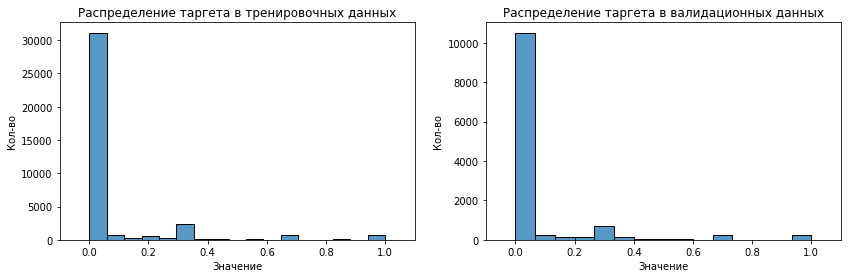

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
sns.histplot(y_trn, ax=ax[0])
sns.histplot(y_vald, ax=ax[1])

ax[0].set_xlim([y_trn.min()-.1, y_trn.max()+.1])
ax[1].set_xlim([y_vald.min()-.1, y_vald.max()+.1])

ax[0].set_title('Распределение таргета в тренировочных данных')
ax[1].set_title('Распределение таргета в валидационных данных')

ax[0].set_ylabel('Кол-во')
ax[1].set_ylabel('Кол-во')

ax[0].set_xlabel('Значение')
ax[1].set_xlabel('Значение');

### Первичная оценка моделей

Для начала протестируем модели с дефолтными гипарпараметрами на кросс-валидации на тренировочном датасете `X_trn`. В качестве метрики указываем `MSE`. По итогам примем решение - для каких моделей целесообразно проводить оптимизацию гиперпараметров.

Рассмотрим:
- `LinearRegression()`
- `LGBMRegressor()`
- `CatBoostRegressor()`
- `FC нейронная сеть`

#### Linear Regression

Замерим `MSE` на кросс-валидации. Обработка данных `StandardScaler` никаких эффектов не даст, т.к. не применяется регуляризация.

In [ ]:
LR_cv_score = cross_validate(LinearRegression(),
                             X_trn.values,
                             y_trn.values,
                             scoring=['neg_mean_squared_error'],
                             cv=gkf,
                             return_train_score=True,
                             verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  neg_mean_squared_error: (train=-0.033, test=-45696232.272) total time=  15.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.1s remaining:    0.0s


[CV] END  neg_mean_squared_error: (train=-0.047, test=-35957529.915) total time=  15.1s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.3s remaining:    0.0s


[CV] END  neg_mean_squared_error: (train=-0.031, test=-46739514.432) total time=  15.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.8s finished


Попробуем замерить другим методом ...

In [ ]:
cross_val_score(LinearRegression(),
                X_trn.values,
                y_trn.values,
                cv=gkf,
                scoring='neg_mean_squared_error')

array([-45696232.27243369, -35957529.91475365, -46739514.43189102])

По-моему с `LinearRegression` все очень плохо ... даже не стОит рассматривать.

#### LGBMRegressor

Аналогчно для `LGBMRegresor` замерим `MSE` на кросс-валидации. Фолды те же самые. Обработка данных `StandardScaler` не нужна т.к. для деревьев это не нужно.

In [ ]:
LGBModel = LGBMRegressor(objective='regression',
                         device_type='gpu',
                         n_estimators=50,
                         random_state=RND_ST)

LGBM_cv_score = cross_validate(LGBModel,               
                               X_trn.values,
                               y_trn.values,
                               scoring=['neg_mean_squared_error'],
                               cv=gkf,
                               return_train_score=True,
                               verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 644912
[LightGBM] [Info] Number of data points in the train set: 24825, number of used features: 2816
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2508 dense feature groups (59.38 MB) transferred to GPU in 0.076910 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.071661
[CV] END  neg_mean_squared_error: (train=-0.023, test=-0.032) total time=  35.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   36.1s remaining:    0.0s


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 645680
[LightGBM] [Info] Number of data points in the train set: 24824, number of used features: 2816
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2511 dense feature groups (59.47 MB) transferred to GPU in 0.075916 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.070442
[CV] END  neg_mean_squared_error: (train=-0.023, test=-0.033) total time=  32.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 645473
[LightGBM] [Info] Number of data points in the train set: 24821, number of used features: 2816
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 2512 dense feature groups (59.46 MB) transferred to GPU in 0.077459 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.067682
[CV] END  neg_mean_squared_error: (train=-0.022, test=-0.035) total time=  32.0s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.7min finished


In [ ]:
np.mean(LGBM_cv_score['test_neg_mean_squared_error']*(-1))

0.03362968205308528

среднее `MSE` уже выглядит более адекватно.

#### CatBoostRegressor

Обработка данных `StandardScaler` не нужна т.к. для деревьев это не нужно.

In [ ]:
CBModel = CatBoostRegressor(random_state=RND_ST,
                            task_type='GPU',
                            devices='0:1',
                            n_estimators=50,
                            verbose=False)


CB_cv_score = cross_validate(CBModel,            
                             X_trn.values,
                             y_trn.values,
                             scoring=['neg_mean_squared_error'],
                             cv=gkf,
                             return_train_score=True,
                             verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  neg_mean_squared_error: (train=-0.027, test=-0.034) total time=  12.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s remaining:    0.0s


[CV] END  neg_mean_squared_error: (train=-0.027, test=-0.034) total time=  11.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.6s remaining:    0.0s


[CV] END  neg_mean_squared_error: (train=-0.026, test=-0.037) total time=  11.2s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.8s finished


In [ ]:
np.mean(CB_cv_score['test_neg_mean_squared_error']*(-1))

0.03498661677835036

`MSE` на валидации чуть больше, чем у `LGBMRegressor`

#### FC нейронная сеть

Задаем первоначальную**\*** конфигурацию модели. Выберем модель с 4 скрытыми слоями, с батчнорм, активация `ReLU`. Дропаут на данном этапе не применяем. Модель протестируем на кросс-валидации на тех же фолдах, что и остальные модели.

**\*** *первоначальная означает, что на данном этапе нам вообще нужно убедится, что модель показывает адекватные метрики.*

In [ ]:
def config_net(input_shape=X_trn.shape[1]):

    inputs = keras.Input(shape=(input_shape,), name='input')

    x = layers.Dense(512, name='dense_1')(inputs)  #512
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(128, name='dense_2')(x)       #128
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(32, name='dense_3')(x)        #32
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(10, name='dense_4')(x)        #10
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Dense(1, activation='relu', name='prediction')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='test_Net')

In [ ]:
NN_btch = 128
NN_epochs = 50

fold_no = 1
for (trn, val) in gkf:
    print('\n------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...\n')
    
    MyNet = config_net()
    MyNet.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  #metrics=['mse'])
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    MyNet.fit(X_trn.values[trn], y_trn.values[trn], batch_size=NN_btch, epochs=NN_epochs, verbose=0)
    val_scores = MyNet.evaluate(X_trn.values[val], y_trn.values[val], batch_size=NN_btch, verbose=1)
    print('\nValidation MSE: %f' % val_scores[1])

    del MyNet
    fold_no +=1


------------------------------------------------------------------------
Training for fold 1 ...

97/97 [==============================] - 0s 3ms/step - loss: 0.0362 - mean_squared_error: 0.0362

Validation MSE: 0.036240

------------------------------------------------------------------------
Training for fold 2 ...

97/97 [==============================] - 0s 3ms/step - loss: 0.0370 - mean_squared_error: 0.0370

Validation MSE: 0.037000

------------------------------------------------------------------------
Training for fold 3 ...

97/97 [==============================] - 1s 5ms/step - loss: 0.0405 - mean_squared_error: 0.0405

Validation MSE: 0.040527


Для дальнейшего рассмотрения выбираем две модели:
- `LGBMRegressor` (чуть точнее чем `CatBoostRegressor`)
- `FC` нейронную сеть

### Подбор гиперпараметров

#### LGBMRegressor

Оптимизация работает довольно долго, поэтому оставил только 1 итеррацию (для демонстрации), указав в комментариях какие диапазоны исследовал.

гиперпараметры, на которых было достигнуто лучшее значение метрики:

```python
{'n_estimators': 589,
'max_depth': 8,
'learning_rate': 0.046157236149846625,
'num_leaves': 67,
'min_data_in_leaf': 63, 
'l1_regularization': 0.0463760438860282}
```


In [ ]:
def objective_LGB(trial, x_train=X_trn.values, y_train=y_trn.values, x_val=X_vald.values, y_val=y_vald.values):
    
    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val)
    
    params = {'random_state': RND_ST,
              'verbose': -1,
              'device_type': 'gpu',
              'metric': 'mse',
              'early_stopping_round': 100,
              'n_estimators': trial.suggest_int('n_estimators', 589, 589),                        # исследовал 100, 800
              'max_depth': trial.suggest_int('max_depth', 8, 8),                                  # исследовал 4, 10
              'learning_rate': trial.suggest_float('learning_rate', .046157236149, .04615723615), # исследовал .01, .1
              'num_leaves': trial.suggest_int('num_leaves', 67, 67),                              # исследовал 40, 100
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 63, 63),                  # исследовал 40, 100
              'l1_regularization': trial.suggest_float('l1_regularization', .0463, .0464)         # исследовал 0, .1
             }
    evals_result ={}
    model = lgb.train(params,
                      dtrain,
                      valid_sets=[dval],
                      valid_names=['valid'],
                      callbacks=[lgb.record_evaluation(evals_result)])
    
    return np.min(evals_result['valid']['l2'])

In [ ]:
study_lgb = optuna.create_study(direction='minimize', study_name='LGBMRegressor')
study_lgb.optimize(objective_LGB, n_trials=1)                                             # исследовал 100

[I 2022-12-20 22:27:40,949] A new study created in memory with name: LGBMRegressor
[I 2022-12-20 22:34:26,614] Trial 0 finished with value: 0.02952434635519498 and parameters: {'n_estimators': 589, 'max_depth': 8, 'learning_rate': 0.046157236149433116, 'num_leaves': 67, 'min_data_in_leaf': 63, 'l1_regularization': 0.0463347066384402}. Best is trial 0 with value: 0.02952434635519498.


In [ ]:
print('Метрика MSE лучшей модели LGBMRegressor на валидации: %f' % (study_lgb.best_value))

Метрика MSE лучшей модели LGBMRegressor на валидации: 0.029524


Обучим модель с найденными оптимальными гиперпараметрами *(все равно нашли - потом проверим на тесте 😏 )*

In [ ]:
LGBModel = lgb.train(params = {**study_lgb.best_params,
                               'random_state': RND_ST,
                               'device_type': 'gpu',
                               'verbose': -1},
                     train_set = lgb.Dataset(data=X_trn, label=y_trn),
                     valid_sets = [lgb.Dataset(data=X_vald, label=y_vald)]             
                     )

#### FC нейронная сеть

Поиск гиперпараметров будем проводить с помощью `Keras Tuner`.

Гиперпараметры, которые будем подбирать:
- кол-во слоев
- кол-во нейронов для каждого из слоев (кроме входного и выходного)
- параметры `Dropout` для каждого из слоев
- `learning_rate`
- размер батча

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
    
    def build(self, hp):
        my_hyp_model = keras.Sequential()
    
        my_hyp_model.add(layers.Input(shape=(self.input_shape,), name='input'))
    
        # Tune the number of layers
        for i in range(hp.Int('num_layers', min_value=2, max_value=3, step=1)):                         
        
            # Tune number of units separately
            my_hyp_model.add( layers.Dense(units=hp.Choice(f'units_{i}', [16, 32, 64, 128, 256, 512, 1024])) )  
            my_hyp_model.add( layers.BatchNormalization() )
            my_hyp_model.add( layers.ReLU() )
        
            # Tune the dropout rate separatly
            my_hyp_model.add( layers.Dropout(rate=hp.Float(f'dp_{i}', min_value=0, max_value=.5, step=.01)) )   
    
        my_hyp_model.add(layers.Dense(1, activation='relu', name='prediction'))
        learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')   
        my_hyp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=keras.losses.MeanSquaredError(),
                             metrics=[tf.keras.metrics.MeanSquaredError()])
        return my_hyp_model

    def fit(self, hp, my_hyp_model, *args, **kwargs):
        return my_hyp_model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [128, 256, 512, 1024, 2048]),
            **kwargs
        )

In [ ]:
my_hypermodel = MyHyperModel(X_trn.shape[1])
my_hypermodel.build(keras_tuner.HyperParameters())

new_tuner = keras_tuner.RandomSearch(
    hypermodel=my_hypermodel,
    objective=keras_tuner.Objective('val_mean_squared_error', direction='min'),
    max_trials=100,
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner',
    project_name='my_hyp_model',
    seed=RND_ST,
)

new_tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}
dp_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
units_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128, 256, 512, 1024], 'ordered': True}
dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.01, 'sampling': None}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


Трансформируем тренировочные и валидационные данные в тензоры `TensorFlow`

In [ ]:
X_trn_tf = tf.constant(X_trn.values)
y_trn_tf = tf.constant(y_trn.values)
X_vald_tf = tf.constant(X_vald.values)
y_vald_tf = tf.constant(y_vald.values)

print('Тензоры тренировочных данных:', X_trn_tf.shape, y_trn_tf.shape)
print('Тензоры валидационных данных:', X_vald_tf.shape, y_vald_tf.shape)

Тензоры тренировочных данных: (37235, 2816) (37235,)
Тензоры валидационных данных: (12483, 2816) (12483,)


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=5)

with tf.device('/device:GPU:0'):
    new_tuner.search(X_trn_tf, y_trn_tf,
                     validation_data=(X_vald_tf, y_vald_tf),
                     epochs=75,
                     callbacks=[stop_early]
                    )

Trial 100 Complete [00h 00m 24s]
val_mean_squared_error: 0.03505953028798103

Best val_mean_squared_error So Far: 0.03221104294061661
Total elapsed time: 00h 24m 23s


Сравним метрики `LGBMRegressor` и нейронной сети:

In [ ]:
new_tuner.results_summary(1)

Results summary
Results in keras_tuner/my_hyp_model
Showing 1 best trials
Trial summary
Hyperparameters:
num_layers: 2
units_0: 256
dp_0: 0.4
units_1: 16
dp_1: 0.26
lr: 0.0001650611068158452
units_2: 32
dp_2: 0.02
batch_size: 128
Score: 0.03221104294061661


In [ ]:
study_lgb.best_value

0.02952434635519498

Метрика заметно отличаются в пользу `LGBMRegressor`. Попробуем обе ✌️ модели на тесте!

Для FC нейронки принимаем решение забрать из тюнера лучшую модель. Модель сохраняется в состоянии эпохи, на которой была получена лучшая метрика на валидации.

[Ссылка на документацию](https://keras.io/guides/keras_tuner/getting_started/#query-the-results)
```
When search is over, you can retrieve the best model(s).
The model is saved at its best performing epoch evaluated on the validation_data
```

In [ ]:
MyNet = new_tuner.get_best_models()[0]
MyNet.build(input_shape=(None, X_trn_tf.shape[1]))
MyNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               721152    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 16)                4112      
                                                                 
 batch_normalization_1 (Batc  (None, 16)               64        
 hNormalization)                                        

## Тестирование

Настало время протестировать модель. Для этого получим векторы для всех тестовых изображений из папки `test_images`, выбираем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выводим наиболее релевантное изображение. Качество поиска можно сравнить визуально.

### Векторизация тестовых изображений

In [ ]:
test_img_flow = datagen.flow_from_dataframe(
    dataframe=test_df[["image"]]
    .drop_duplicates()
    .sort_values("image")
    .reset_index(drop=True),
    directory=DATA_PATH + "/test_images",
    x_col="image",
    target_size=IMG_SHAPE[:2],
    batch_size=10,
    class_mode=None,
    subset=None,
    shuffle=False,
)

Found 100 validated image filenames.


In [ ]:
#with tf.device('/cpu:0'):
with tf.device('/device:GPU:0'):
    test_img_vectors = fch_extraction.predict(test_img_flow, verbose=1)

10/10 [==============================] - 1s 56ms/step


In [ ]:
test_img_vectors.shape, type(test_img_vectors)

((100, 2048), numpy.ndarray)

In [ ]:
test_img_vectors_df = pd.DataFrame(test_img_vectors).join(
    test_df[["image"]].drop_duplicates().sort_values("image").reset_index(drop=True)
)
test_img_vectors_df.columns = [
    "iv_" + str(colname) for colname in test_img_vectors_df.columns
]
test_img_vectors_df.rename(columns={"iv_image": "image"}, inplace=True)
display(test_img_vectors_df.head(3))
print(test_img_vectors_df.shape)

iv_0      iv_1      iv_2      iv_3      iv_4      iv_5      iv_6  \
0  0.000000  0.306870  0.024604  0.000000  0.000000  0.000000  0.117842   
1  0.023740  0.844274  0.000000  0.000000  0.220968  0.003424  0.340974   
2  0.000164  0.702930  0.139352  0.867324  0.017876  0.000000  0.024905   

       iv_7      iv_8      iv_9  ...   iv_2039   iv_2040  iv_2041   iv_2042  \
0  0.000000  0.043956  0.025718  ...  0.272331  0.308783      0.0  0.042691   
1  0.544601  0.079752  0.008131  ...  0.198423  0.928309      0.0  0.014539   
2  0.046367  0.000000  0.057214  ...  0.352275  0.861486      0.0  0.197070   

    iv_2043   iv_2044   iv_2045   iv_2046   iv_2047                      image  
0  0.021700  1.018959  0.325576  0.227259  0.000000  1177994172_10d143cb8d.jpg  
1  2.024559  0.820306  0.115006  0.059178  0.058275  1232148178_4f45cc3284.jpg  
2  0.004631  1.369453  0.215454  0.000000  0.028704   123997871_6a9ca987b1.jpg  

[3 rows x 2049 columns]

(100, 2049)


Файл с именами тестовых изображений и их векторами - готов

### Поиск изображения по описанию

Создадим список всех тестовых описаний - из него мы будем случайно выбирать описания и отправлять их в функцию, которая будет искать для этого описания наиболее релевантную картинку.

In [ ]:
test_queries = test_df['query_text'].drop_duplicates()
test_queries

0      Two blonde boys , one in a camouflage shirt an...
1      Two boys are squirting water guns at each other .
2                Two boys spraying each other with water
3      Two children wearing jeans squirt water at eac...
4      Two young boys are squirting water at each oth...
                             ...                        
495            A black dog has a dumbbell in his mouth .
496    A black dog has a dumbbell in his mouth lookin...
497    A black dog holding a weight in its mouth stan...
498    A black dog holds a small white dumbbell in it...
499    The black dog has a toy in its mouth and a per...
Name: query_text, Length: 500, dtype: object

Функция `img_by_text` получает на вход:
- текстовое описание
- упорядоченный список векторов всех тестовых картинок
- модель
- адрес папки где лежат тестовые картинки.

Функция находит для полученного описания эмбеддинг, дополняет упорядоченный файл векторов этим эмбеддингом, далее модель прогнозирет оценки для всех пар "вектор изображения + эмбеддинг". Далее находим индекс максимальной оценки среди прогноза, по этому индексу в фале векторов находии название изображения и выводим картинку, которая по мнению  модели максимально соответствует описанию.

In [ ]:
def img_by_text(query, img_base=test_img_vectors_df, model=MyNet, img_dir=DATA_PATH +'/test_images/'):
    
    print('\n------------------------------------------------------------------------')
    print('Запрос:', query, '\n')
    query_lemm = text_prep(query)
    
    if sum([word in query_lemm for word in compliance_words]) != 0:
        print('This image is unavailable in your country in compliance with local laws.\n')
    else:
        query_emb_df1 = pd.DataFrame( text_embedding(pd.Series(query_lemm)) )
        query_emb_df = pd.concat([query_emb_df1]*img_base.shape[0], ignore_index=True)
        query_emb_df.columns = ['te_' + str(colname) for colname in query_emb_df.columns]
        fch_tf = tf.constant( pd.concat([img_base, query_emb_df], axis=1).drop(columns=['image']) )
        preds = model.predict(fch_tf).flatten()
        
        # вывод максимального значения прогноза модели 
        print('\nИндекс соответствия по прогнозу модели:', np.max(preds), '\n')
        img_path = img_dir + img_base['image'].iloc[np.argmax(preds)]
        img = keras.utils.load_img(img_path, target_size=(320, 320))
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow( keras.utils.img_to_array(img) /255. )
        ax.axis('off')
        plt.show()

**Нейронная сеть**


------------------------------------------------------------------------
Запрос: Person jumping into the water . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.18496636 



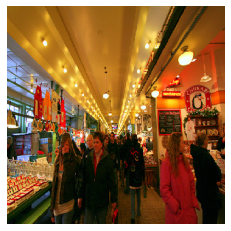


------------------------------------------------------------------------
Запрос: A child in a green shirt balancing on a red rope while holding two white ropes . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: A little white dog runs on freshly mown grass , holding a small stick . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.2511634 



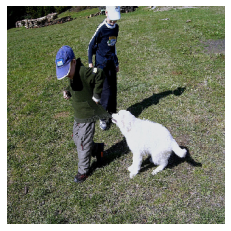


------------------------------------------------------------------------
Запрос: Men in a khaki-colored tent outside in a rundown area . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.0671151 



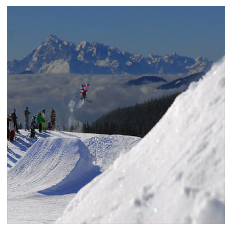


------------------------------------------------------------------------
Запрос: Young children shoot baskets in the field . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: A boy with an orange tool on the shore is spraying a girl standing in shallow water with mud . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: Boy wearing a green and white soccer uniform running through the grass . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: An elderly woman sits on a tree stump with a white dog . 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step

Индекс соответствия по прогнозу модели: 0.05086559 



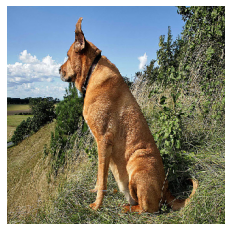


------------------------------------------------------------------------
Запрос: A girl in a pool wearing goggles and surrounded by other children 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: Two black dogs are fighting over a toy 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 4ms/step

Индекс соответствия по прогнозу модели: 0.062006637 



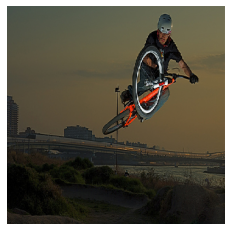

In [ ]:
for _ in range(10):
    img_by_text( test_queries[random.randint(0, len(test_queries))] )

Результаты честно говоря ... не очень 😬

Бустинг **LGBMRegressor**


------------------------------------------------------------------------
Запрос: Four people playing basketball on wooden area near the beach . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.12710494902203542 



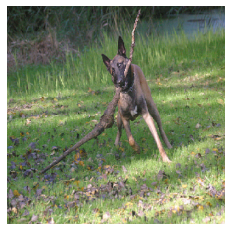


------------------------------------------------------------------------
Запрос: a kickboxer jumping for a kick 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.3070129107508886 



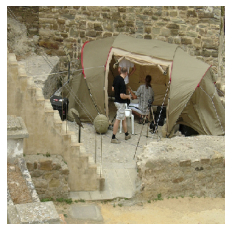


------------------------------------------------------------------------
Запрос: A woman walks and a little boy walks to the side of her . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: The brown German shepherd dog is playing with a stick . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.10087324267216537 



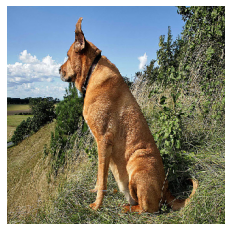


------------------------------------------------------------------------
Запрос: The baby is wearing a red shirt and walking in a plaza . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: Woman in colorful shirt works at sewing machine . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.07576921593914467 



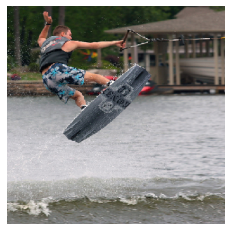


------------------------------------------------------------------------
Запрос: A woman in a red coat takes a picture near marble columns at twilight . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.12142897620457577 



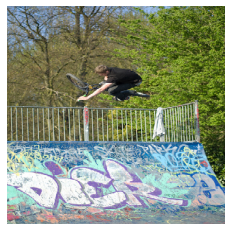


------------------------------------------------------------------------
Запрос: A boy in blue is riding his bike in a skate park . 

This image is unavailable in your country in compliance with local laws.


------------------------------------------------------------------------
Запрос: Skier in red skiing down a snowy mountain . 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.27648521527325803 



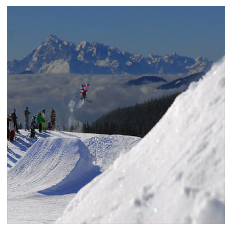


------------------------------------------------------------------------
Запрос: The three children are standing on and by a fence . 

This image is unavailable in your country in compliance with local laws.



In [ ]:
for _ in range(10):
    img_by_text( test_queries[random.randint(0, len(test_queries))], model=LGBModel )

Не очень-то "попадает" модель 😕

## Вывод

На мой взгляд полученные в проекте модели малопригодны для поиска релевантного изображения по текстовому описанию. По крайней мере на доступном кол-ве данных модели не обучились. Нужно значительно больше данных (хотя бы раз в 10 больше) и нужна бОльшая вариативность оценок - следовало бы увеличил число экспертов допустим до 10.